In [350]:
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn import svm
import seaborn as sns
import pandas as pd
import numpy as np
import csv 
plt.rcParams['figure.figsize'] = [15, 10]

df = pd.read_csv('vs.csv',header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab


# Data Preparation
The first step is to ensure that the columns can be references with a string value. 
e.g. 0 refers to Compactness. 

In [351]:
df.columns = ['COMPACTNESS','CIRCULARITY','DISTANCE ','RADIUS_RATIO', 'AXIS_ASPECT_RATIO','LENGTH_ASPECT_RATIO',
              'SCATTER_RATIO','ELONGATEDNESS','AXIS_RECTANGULARITY','LENGTH_RECTANGULARITY','VARIANCE_MAJOR',
              'VARIANCE_MINOR','RADIUS_GYRATION','SKEWNESS_MAJOR','SKEWNESS_MINOR','KURTOSIS_MINOR','KURTOSIS_MAJOR',
              'HOLLOWS_RATIO','CLASS']
df.head(3)

,COMPACTNESS,CIRCULARITY,DISTANCE,RADIUS_RATIO,AXIS_ASPECT_RATIO,LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,AXIS_RECTANGULARITY,LENGTH_RECTANGULARITY,VARIANCE_MAJOR,VARIANCE_MINOR,RADIUS_GYRATION,SKEWNESS_MAJOR,SKEWNESS_MINOR,KURTOSIS_MINOR,KURTOSIS_MAJOR,HOLLOWS_RATIO,CLASS
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab


The next step is to ensure that the missing values are dealth with.

In [352]:
#check if any data field is missing
df[df.isnull().any(axis=1)]

,COMPACTNESS,CIRCULARITY,DISTANCE,RADIUS_RATIO,AXIS_ASPECT_RATIO,LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,AXIS_RECTANGULARITY,LENGTH_RECTANGULARITY,VARIANCE_MAJOR,VARIANCE_MINOR,RADIUS_GYRATION,SKEWNESS_MAJOR,SKEWNESS_MINOR,KURTOSIS_MINOR,KURTOSIS_MAJOR,HOLLOWS_RATIO,CLASS


As all values are valid, we move on without making big changes. The next step is to find outliers, if any, and balance the data out.

In [353]:
def movingAverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

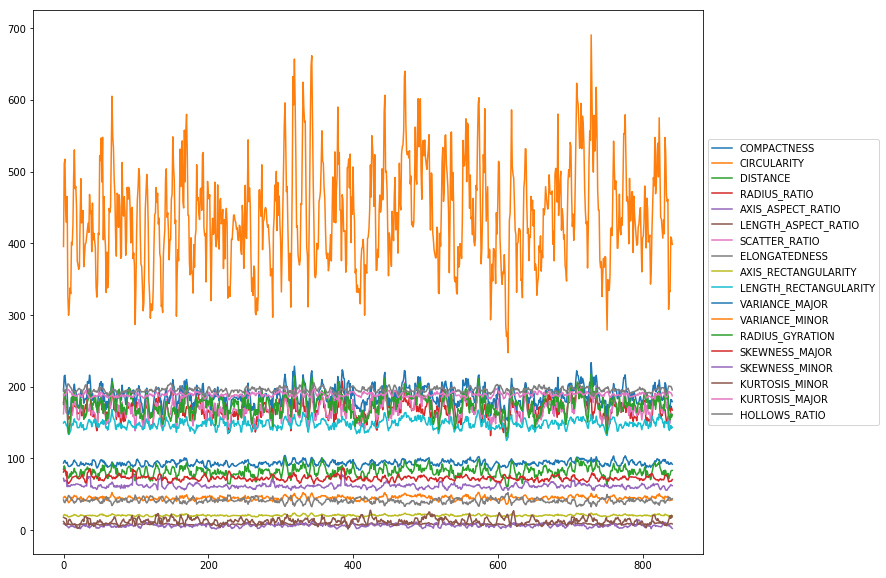

In [354]:
flag = 0
x = np.arange(0,len(df)-4)
fig = plt.figure()
ax = plt.subplot(111)
#Firstly, change all numeric values to type int. The class is changed to int, too.
#Then, calculate the moving average to look for outliers.
for col in df.columns:
    if col != 'CLASS':
        for row in df[col]:
            row = int(row)
        elements = np.array(df[col])
        ma = movingAverage(elements, 5)
        ax.plot(x,ma,label=col)
    else:
        continue
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

It appears that hollows_ratio has the most number of outliers. Given the nature of the data, and the normal distribution of the other features, we choose not to remove any data point. 
<br> Note: The UCI ML Dataset comes with pre-prepared data that lets us easily move to the next step of the modelisation process.
Now, to find the distribution of the 'class' feature, which here is the independant variable.

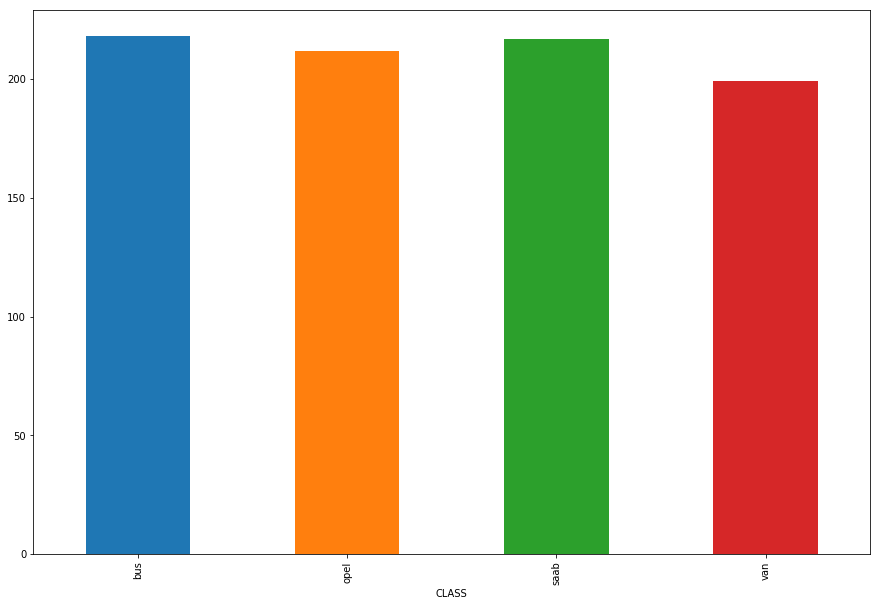

In [355]:
cl_count = df.groupby(['CLASS']).size()
cl_count.plot.bar()

The distribution is rather uniform which would mean that the model will learn in a uniform manner. Next, we check the correlation of each feature with the class to avoid overfitting and overlearning. 

In [356]:
for col in df.columns:
    cor = df.groupby('CLASS')[[col]].corr()
    print cor

                   COMPACTNESS
CLASS                         
bus   COMPACTNESS          1.0
opel  COMPACTNESS          1.0
saab  COMPACTNESS          1.0
van   COMPACTNESS          1.0
                   CIRCULARITY
CLASS                         
bus   CIRCULARITY          1.0
opel  CIRCULARITY          1.0
saab  CIRCULARITY          1.0
van   CIRCULARITY          1.0
                 DISTANCE 
CLASS                     
bus   DISTANCE         1.0
opel  DISTANCE         1.0
saab  DISTANCE         1.0
van   DISTANCE         1.0
                    RADIUS_RATIO
CLASS                           
bus   RADIUS_RATIO           1.0
opel  RADIUS_RATIO           1.0
saab  RADIUS_RATIO           1.0
van   RADIUS_RATIO           1.0
                         AXIS_ASPECT_RATIO
CLASS                                     
bus   AXIS_ASPECT_RATIO                1.0
opel  AXIS_ASPECT_RATIO                1.0
saab  AXIS_ASPECT_RATIO                1.0
van   AXIS_ASPECT_RATIO                1.0
          

In [357]:
for i in range (len(df['CLASS'])):
    if df.at[i,'CLASS'] == 'bus':
        df.at[i,'CLASS'] = 1
    elif df.at[i,'CLASS'] == 'opel':
        df.at[i,'CLASS'] = 2
    elif df.at[i,'CLASS'] == 'van':
        df.at[i,'CLASS'] = 4
    elif df.at[i,'CLASS'] == 'saab':
        df.at[i,'CLASS'] = 3
    else:
        continue

All features seem to have a correlation of 1 meaning that each feature is equally important. We can implement a model and then check how or if the importance varies. The dataset needs to first be divided into test and train. In this project, we try different splits: 50-50,70-30 and 80-20. We notice that due to such a correlation, overfitting may not occur but we still have a chance of 'underfitting'. The train/test data pairs must be properly chosen. Before the split, we must also denote the class values with integers.

#### 50-50

In [358]:
x = df.loc[:, df.columns != 'CLASS']
y = df['CLASS'].values
dx_train, dx_test, dy_train, dy_test = train_test_split(x, y, test_size=0.5)
dx_train.shape, dx_test.shape
dy_train.shape, dy_test.shape
dy_train = dy_train.astype('int')
dy_test = dy_test.astype('int')

##### One vs Rest

In [359]:
pred = OneVsRestClassifier(linear_model.SGDClassifier(max_iter=1000, tol=1e-3)).fit(dx_train, dy_train).predict(dx_test)
pred = pred.astype('int')
accuracy_score(dy_test, pred)


0.23167848699763594

##### One vs One

In [360]:
pred = OneVsOneClassifier(linear_model.SGDClassifier(max_iter=1000, tol=1e-3)).fit(dx_train, dy_train).predict(dx_test)
pred = pred.astype('int')
accuracy_score(dy_test, pred)

0.29550827423167847

Repeating the same for the other splits. 
#### 70-30

In [361]:
x2 = df.loc[:, df.columns != 'CLASS']
y2 = df['CLASS'].values
dx_train, dx_test, dy_train, dy_test = train_test_split(x2, y2, test_size=0.3)
dx_train.shape, dx_test.shape
dy_train.shape, dy_test.shape
dy_train = dy_train.astype('int')
dy_test = dy_test.astype('int')

##### One Vs Rest

In [362]:
pred = OneVsRestClassifier(linear_model.SGDClassifier(max_iter=1000)).fit(dx_train, dy_train).predict(dx_test)
pred = pred.astype('int')
accuracy_score(dy_test, pred)

0.7086614173228346

##### One Vs One

In [363]:
pred = OneVsOneClassifier(linear_model.SGDClassifier(max_iter=1000, tol=1e-3)).fit(dx_train, dy_train).predict(dx_test)
pred = pred.astype('int')
accuracy_score(dy_test, pred)

0.4881889763779528

#### 80-20

In [364]:
x2 = df.loc[:, df.columns != 'CLASS']
y2 = df['CLASS'].values
dx_train, dx_test, dy_train, dy_test = train_test_split(x2, y2, test_size=0.2)
dx_train.shape, dx_test.shape
dy_train.shape, dy_test.shape
dy_train = dy_train.astype('int')
dy_test = dy_test.astype('int')

##### One Vs Rest

In [365]:
pred = OneVsRestClassifier(linear_model.SGDClassifier(max_iter=1000)).fit(dx_train, dy_train).predict(dx_test)
pred = pred.astype('int')
accuracy_score(dy_test, pred)

0.6529411764705882

##### One Vs One

In [366]:
pred = OneVsOneClassifier(linear_model.SGDClassifier(max_iter=1000, tol=1e-3)).fit(dx_train, dy_train).predict(dx_test)
pred = pred.astype('int')
accuracy_score(dy_test, pred)

0.5058823529411764

#### Hyperparameters 
The performance is a little underwhelming in all cases. This calls for hyperparamter regularisation. This will be done using parfit. Starting by splitting the data into a 60-20-20 train, validate, test split.

In [367]:
x = df.loc[:, df.columns != 'CLASS']
y = df['CLASS'].values
#y = label_binarize(y,)
dx_train, dx_test, dy_train, dy_test = train_test_split(x, y, test_size=0.2, random_state=1)
dx_train, dx_val, dy_train, dy_val = train_test_split(dx_train, dy_train, test_size=0.2, random_state=1)
dx_train.shape
dx_test.shape
dx_val.shape
dy_train = dy_train.astype('int')
dy_test = dy_test.astype('int')
dy_val = dy_val.astype('int')

Steps in hyperparameter regularisation using parfit:

1. Create an effective validation set
2. Choose your model
3. Create a parameter grid to evaluate the model over on the validation set
4. Use parfit to visualise the scores over the grid and select the best model
5. Re-train model on full training set, using best parameters from parfit
6. Apply re-trained model to test set

['estimator__epsilon', 'estimator__power_t', 'estimator__average', 'n_jobs', 'estimator__fit_intercept', 'estimator__learning_rate', 'estimator__class_weight', 'estimator__random_state', 'estimator__warm_start', 'estimator__max_iter', 'estimator__l1_ratio', 'estimator__alpha', 'estimator__n_iter', 'estimator__eta0', 'estimator__verbose', 'estimator', 'estimator__n_jobs', 'estimator__penalty', 'estimator__shuffle', 'estimator__loss', 'estimator__tol']
-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.0s remaining:   34.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   24.3s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


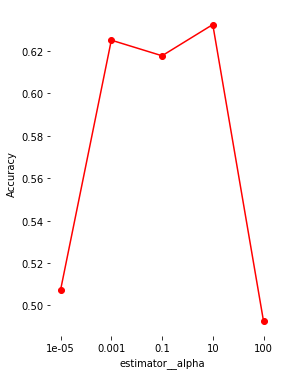

(OneVsRestClassifier(estimator=SGDClassifier(alpha=10, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1), 0.6323529411764706, [OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1), OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
     

In [368]:
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score

grid = {
    "estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1, 10**2],
    #'estimator__learning_rate': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'estimator__n_iter': [1000], # number of epochs
    'estimator__loss': ['log'], # logistic regression,
    'estimator__penalty': ['l2'], #penalty
    'estimator__n_jobs': [-1]
}

print OneVsRestClassifier(linear_model.SGDClassifier()).get_params().keys() #ensuring that the parameters are chosen well
paramGrid = ParameterGrid(grid)
print pf.bestFit(OneVsRestClassifier(linear_model.SGDClassifier()), paramGrid, dx_train, dy_train, dx_val, dy_val, metric = accuracy_score, scoreLabel = "Accuracy")

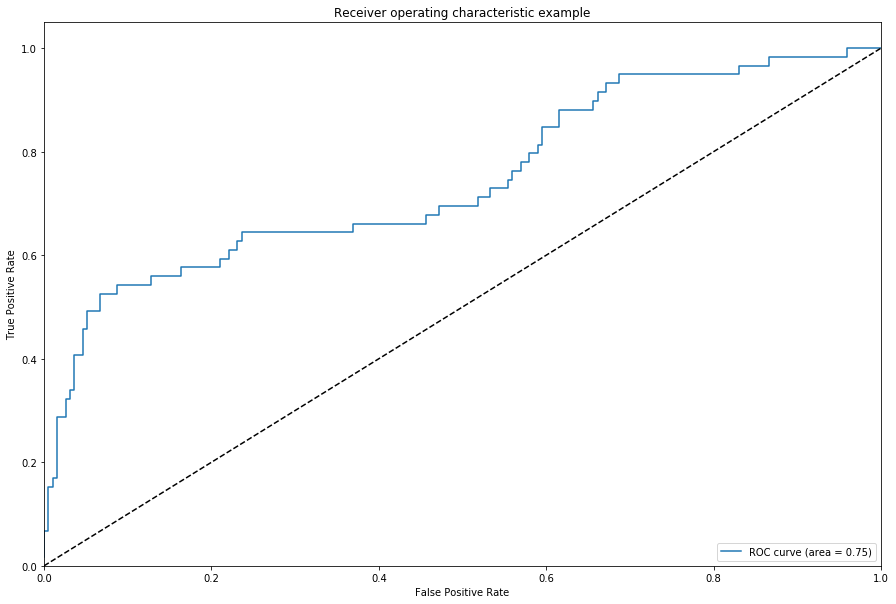

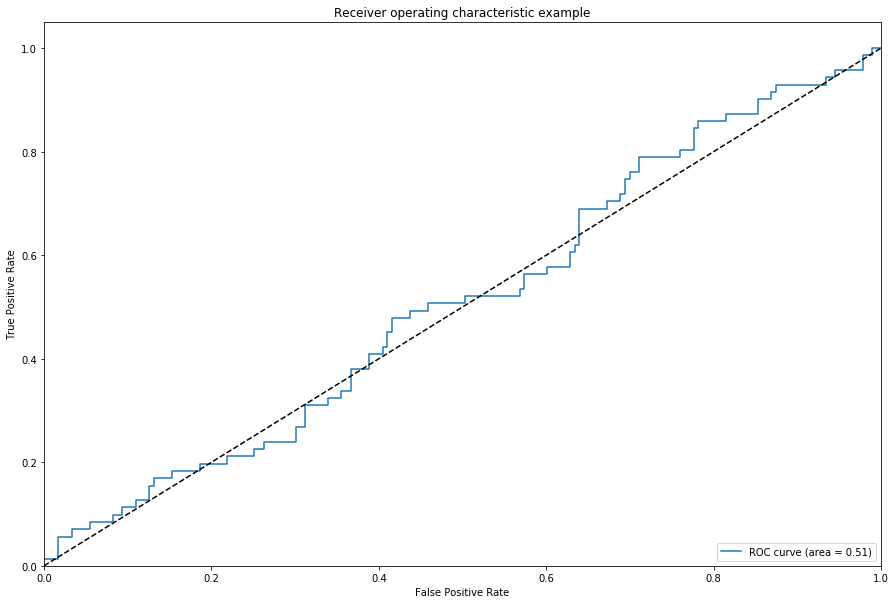

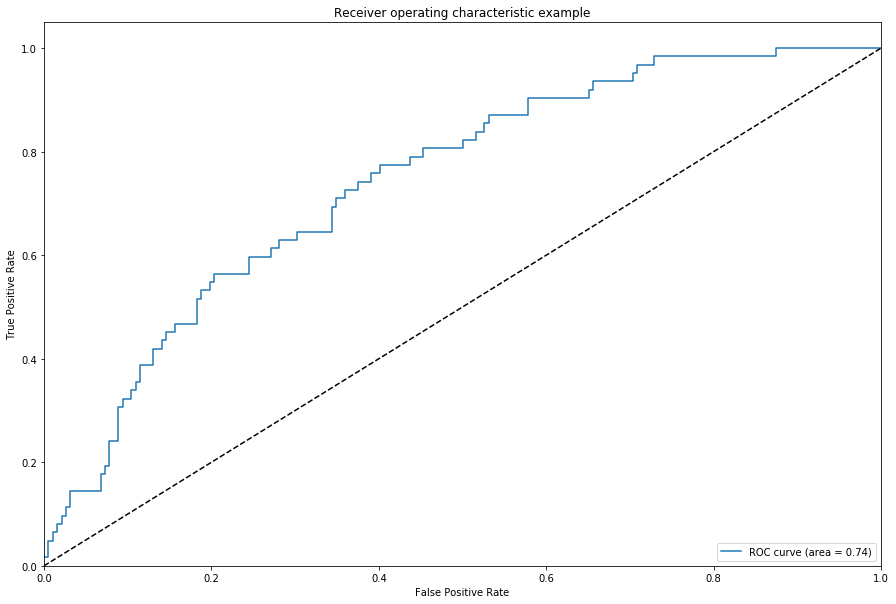

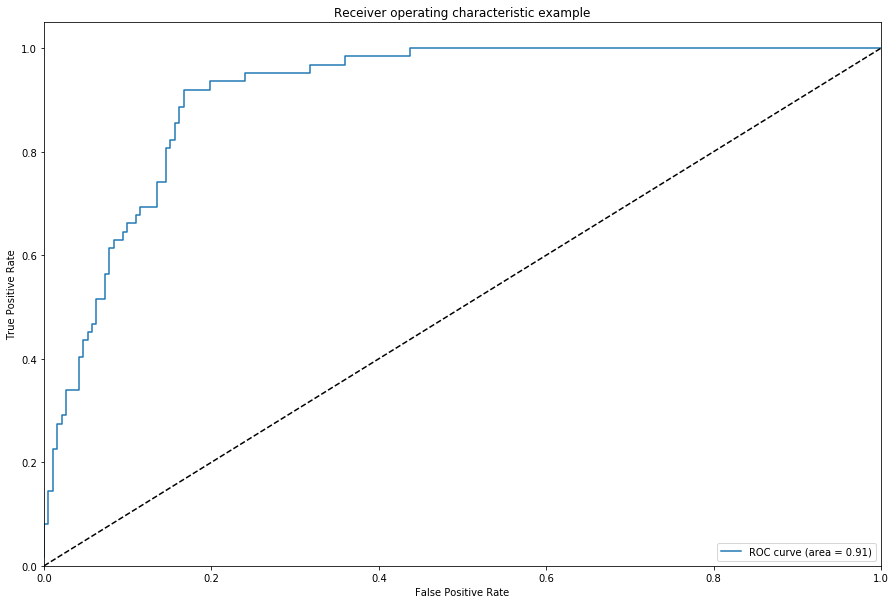

In [370]:
x = df.loc[:, df.columns != 'CLASS']
y = df['CLASS'].values
y = y.astype('int')
y = label_binarize(y,classes=[1,2,3,4])
dx_train, dx_test, dy_train, dy_test = train_test_split(x, y, test_size=0.3, random_state=1)
dx_train.shape
dx_test.shape
dy_train = dy_train.astype('int')
dy_test = dy_test.astype('int')

n_classes = 4

# classifier
clf = OneVsRestClassifier(linear_model.SGDClassifier(random_state=0,alpha=0.00001))
dy_score = clf.fit(dx_train, dy_train).decision_function(dx_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(dy_test[:, i], dy_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()